In [1]:
# dependencies import
from common_dependencies import *
from train_dependencies import *

In [2]:
# paths for files with original data
PATH_TO_DATA = {
    'run_1': 
        ('data/original_data/run_1/run1_WM32_data.csv',
        'data/original_data/run_1/run1_WM32_defects.csv',
        'data/original_data/run_1/run1_WM32_pipe.csv'),
    'run_2':
        ('data/original_data/run_2/run2_WM32_data.csv',
        'data/original_data/run_2/run2_WM32_defects.csv',
        'data/original_data/run_2/run2_WM32_pipe.csv')
}

CROP_SIZE = 16
CROP_STEP = 4
PART_OF_DATA = 200

# детерминация случайных величин, отвечающих за выбор первоначальных весов и биасов
tf.compat.v1.set_random_seed(290)
tf.random.set_seed(290)
np.random.seed(290)

In [3]:
data = {}
x_df, y_df = dw.get_x_and_y_data(*PATH_TO_DATA['run_1'])
data['run_1'] = {'x_df': x_df, 'y_df': y_df}

x_df, y_df = dw.get_x_and_y_data(*PATH_TO_DATA['run_2'])
data['run_2'] = {'x_df': x_df, 'y_df': y_df}

||||||||||||||||||
Original data reading
Read detectors data shape: (115, 400)
Read defect data shape: (115, 400)
||||||||||||||||||

||||||||||||||||||
Original data reading
Read detectors data shape: (119, 400)
Read defect data shape: (119, 400)
||||||||||||||||||



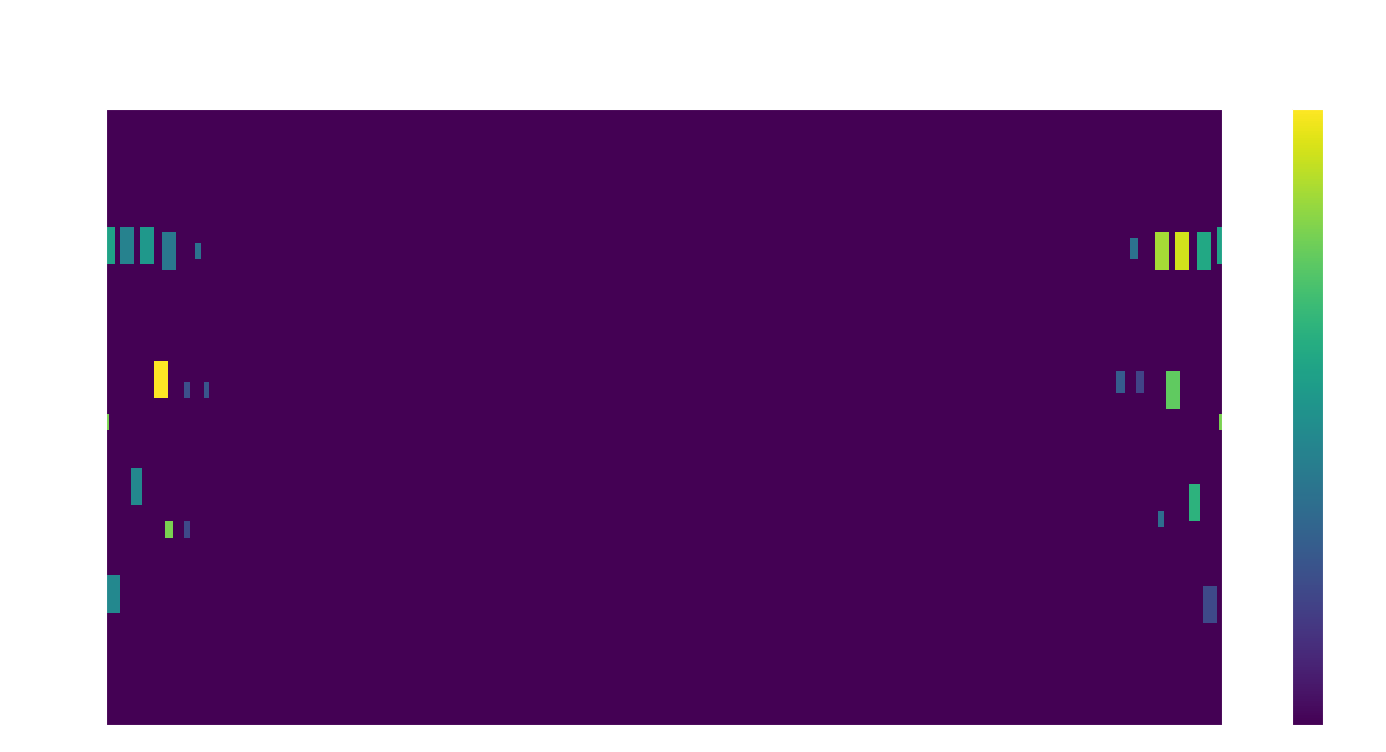

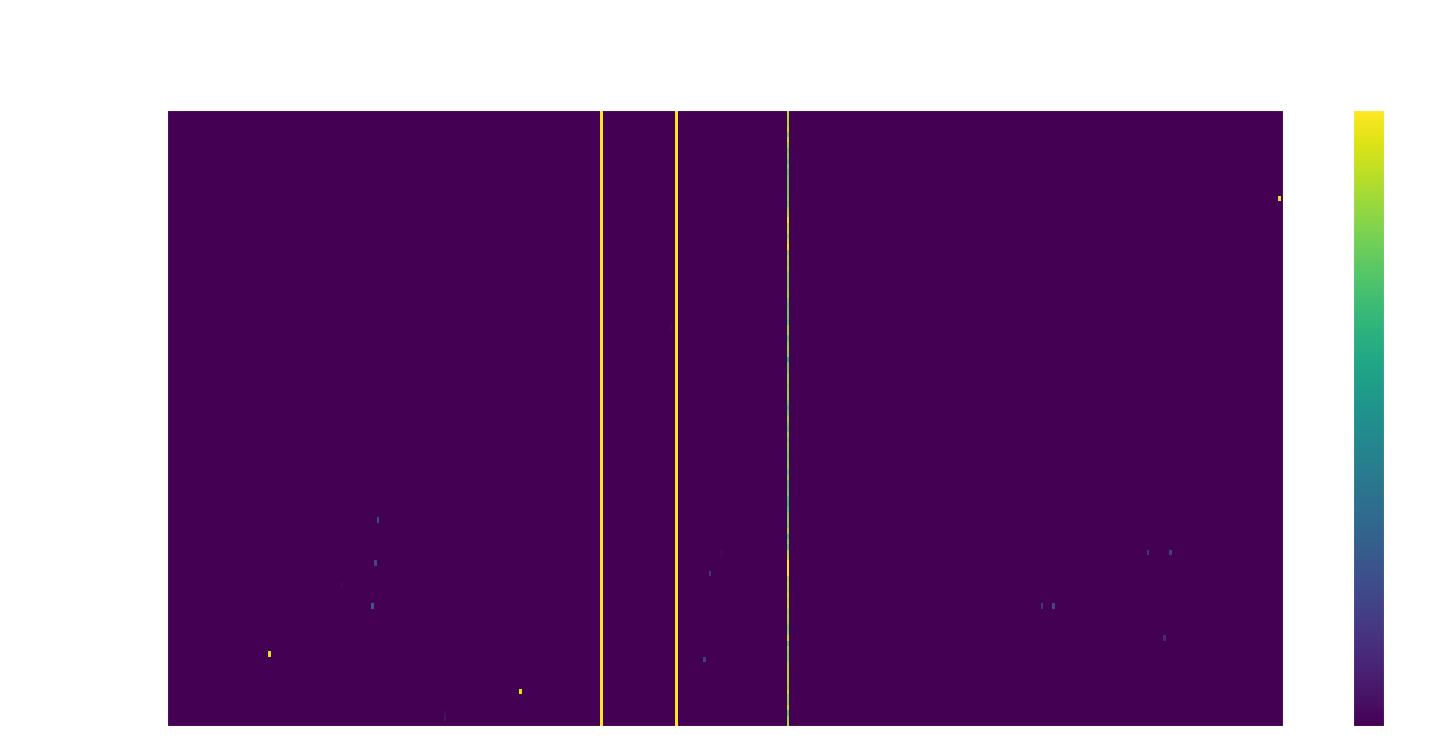

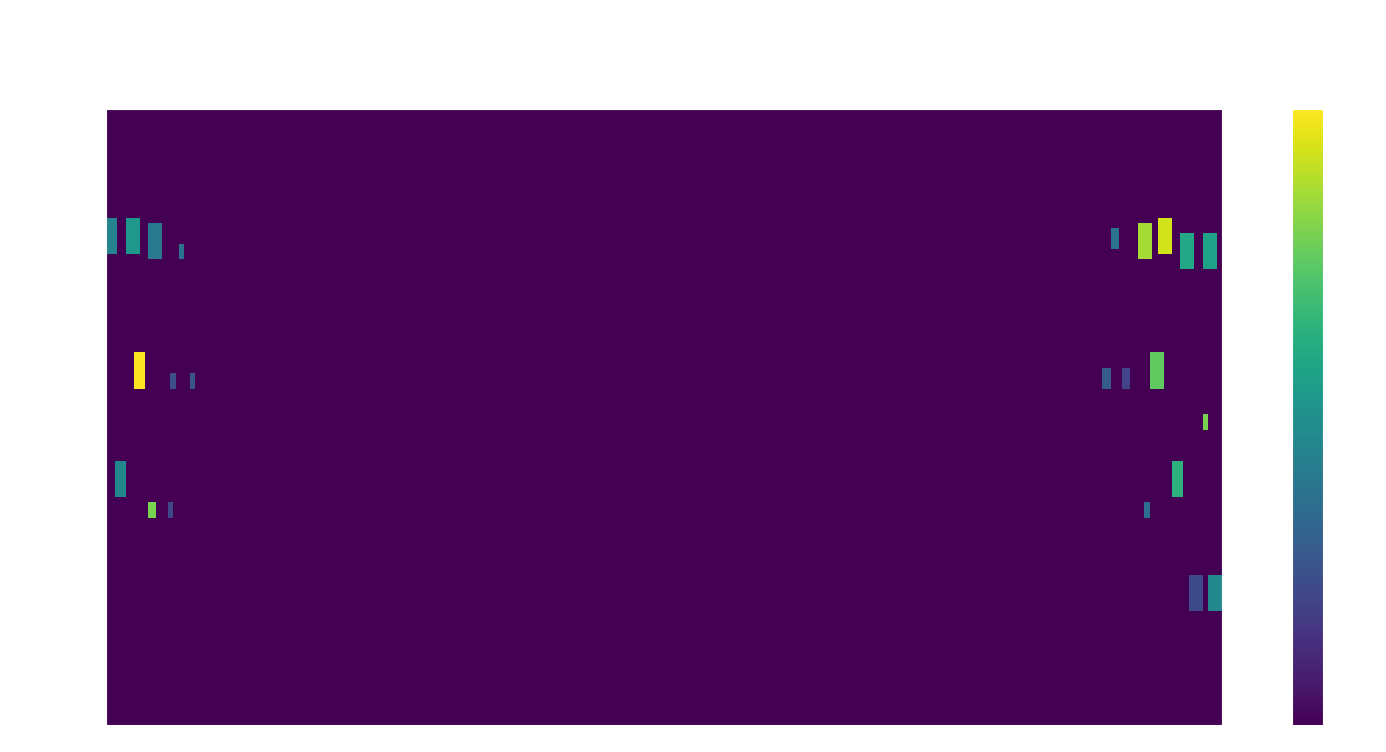

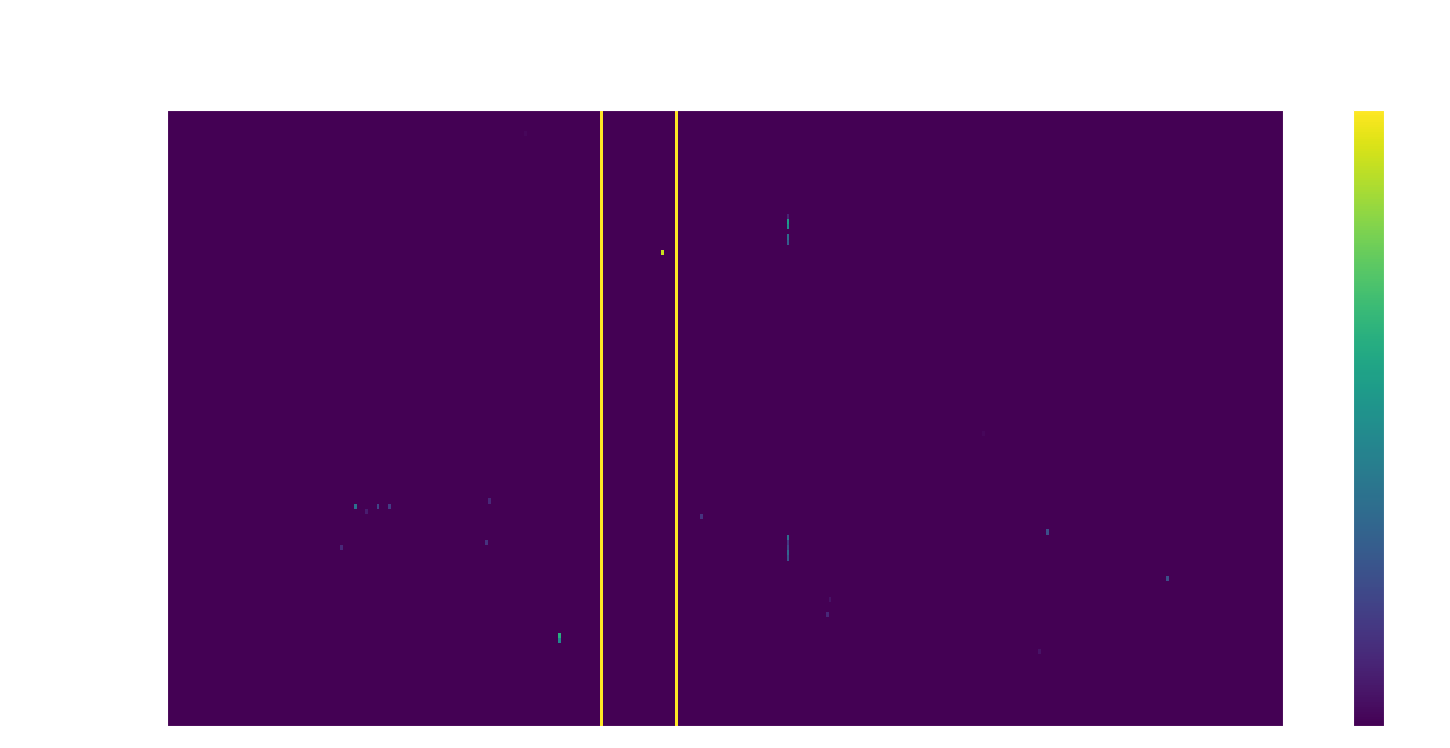

In [4]:
for run, value in data.items():
    dw.draw_defects_map(value['y_df'], title=f'Считанная развернутая карта дефектов для {run}')
    dw.draw_zeros_quantity_in_data_df(value['x_df'], 
                                      title=f'Кол-во 0 значений в считанном датафрейме из данных детекторов для {run}')

In [5]:
# Take the first left half of each file as train and val dataset
'''for run, value in data.items():
    print('/'*8, run,'/'*8)
    for data_part_name, data_part in value.items():
        print(f'{data_part_name} original shape: {value[data_part_name].shape}', end=' -> ')
        value[data_part_name] = value[data_part_name].iloc[:,:PART_OF_DATA]
        print(f'sliced shape: {value[data_part_name].shape}')
    print()'''

print(f"run_1.x_df original shape: {data['run_1']['x_df'].shape}")
print(f"run_1.y_df original shape: {data['run_1']['y_df'].shape}")
data['run_1']['x_df'] = data['run_1']['x_df'].iloc[:,:PART_OF_DATA]
data['run_1']['y_df'] = data['run_1']['y_df'].iloc[:,:PART_OF_DATA]
print(f"run_1.x_df sliced shape: {data['run_1']['x_df'].shape}")
print(f"run_1.y_df sliced shape: {data['run_1']['y_df'].shape}")

print()

print(f"run_2.x_df original shape: {data['run_2']['x_df'].shape}")
print(f"run_2.y_df original shape: {data['run_2']['y_df'].shape}")
data['run_2']['x_df'] = data['run_2']['x_df'].iloc[:,-PART_OF_DATA:]
data['run_2']['y_df'] = data['run_2']['y_df'].iloc[:,-PART_OF_DATA:]
print(f"run_2.x_df sliced shape: {data['run_2']['x_df'].shape}")
print(f"run_2.y_df sliced shape: {data['run_2']['y_df'].shape}")

run_1.x_df original shape: (115, 400)
run_1.y_df original shape: (115, 400)
run_1.x_df sliced shape: (115, 200)
run_1.y_df sliced shape: (115, 200)

run_2.x_df original shape: (119, 400)
run_2.y_df original shape: (119, 400)
run_2.x_df sliced shape: (119, 200)
run_2.y_df sliced shape: (119, 200)


In [6]:
def extend_df_for_prediction(df, crop_size: int, crop_step: int) -> pd.DataFrame:

    print('||||||||||||||||||')
    print('extend_df_for_prediction (only mirroring)')
    print('input df shape: ', df.shape, end=' -> ')
    extend_dims = crop_size - 1
    
    df = pd.concat([df.iloc[:,extend_dims:0:-1], df, df.iloc[:,-2:-extend_dims-2:-1]],axis=1)
    df = pd.concat([df.iloc[extend_dims:0:-1,:], df, df.iloc[-2:-extend_dims-2:-1,:]],axis=0)
    print('output shape: ', df.shape)
    print('||||||||||||||||||\n')
    return df

In [7]:
# extend dfs for better prediction and for crops dividing
for run, value in data.items():
    print('/'*8, run,'/'*8)
    for data_part_name, data_part in value.items():
        print(data_part_name)
        value[data_part_name] = dw.extend_df_for_prediction(value[data_part_name], 
                                                            crop_size=CROP_SIZE, crop_step=CROP_STEP)
        value[data_part_name] = dw.extend_df_for_crops_dividing(value[data_part_name], 
                                                                crop_size=CROP_SIZE, crop_step=CROP_STEP)
    print()

//////// run_1 ////////
x_df
||||||||||||||||||
extend_df_for_prediction (only mirroring)
input df shape:  (115, 200) -> output shape:  (145, 230)
||||||||||||||||||

||||||||||||||||||
extend_df_for_crops_dividing
input df shape:  (145, 230) -> output shape:  (148, 232)
||||||||||||||||||

y_df
||||||||||||||||||
extend_df_for_prediction (only mirroring)
input df shape:  (115, 200) -> output shape:  (145, 230)
||||||||||||||||||

||||||||||||||||||
extend_df_for_crops_dividing
input df shape:  (145, 230) -> output shape:  (148, 232)
||||||||||||||||||


//////// run_2 ////////
x_df
||||||||||||||||||
extend_df_for_prediction (only mirroring)
input df shape:  (119, 200) -> output shape:  (149, 230)
||||||||||||||||||

||||||||||||||||||
extend_df_for_crops_dividing
input df shape:  (149, 230) -> output shape:  (152, 232)
||||||||||||||||||

y_df
||||||||||||||||||
extend_df_for_prediction (only mirroring)
input df shape:  (119, 200) -> output shape:  (149, 230)
||||||||||||||||||

||||

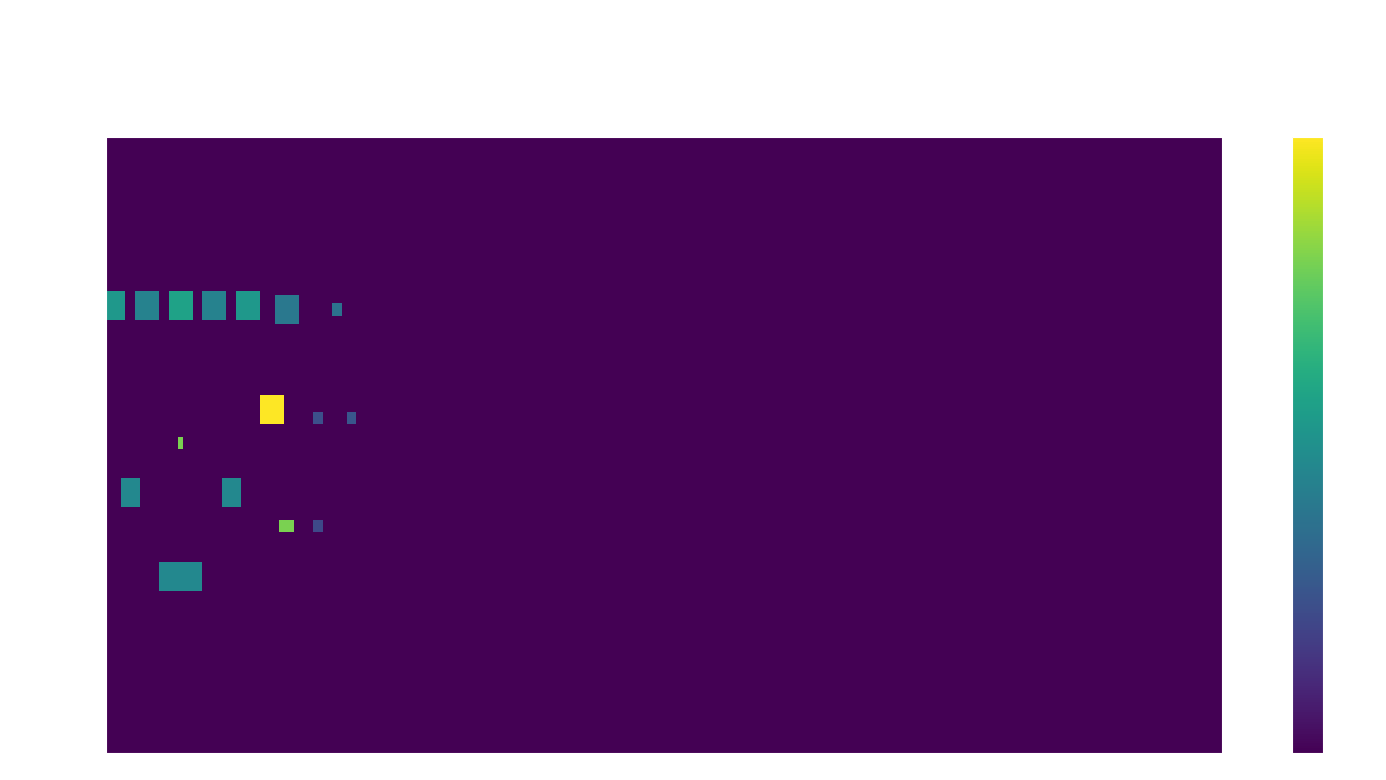

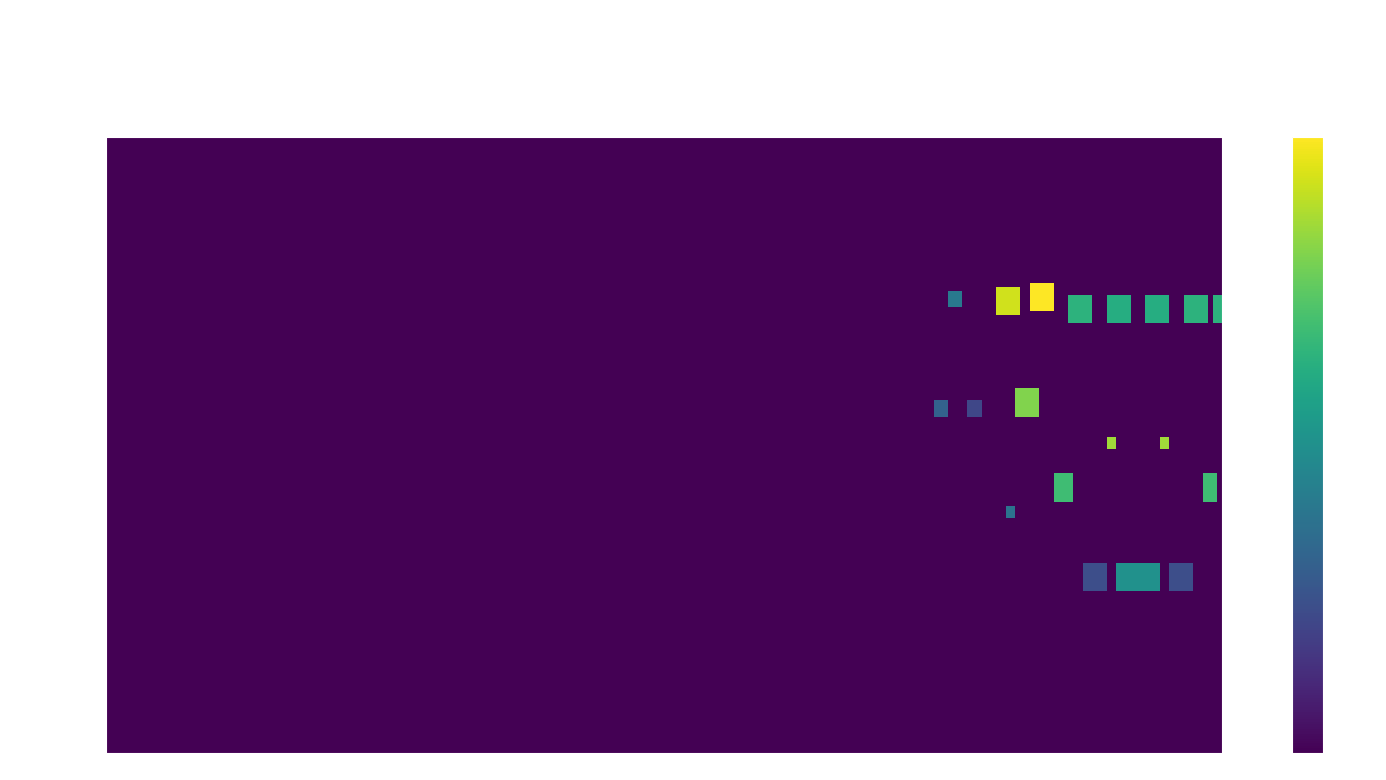

In [8]:
for run, value in data.items():
    dw.draw_defects_map(value['y_df'], title=f'Расширенная развернутая карта дефектов для {run}')

In [9]:
# преобразовать данные к виду (измерение, размер х, размер у, каналы)
# для x_data_time каналы = 32
# для x_data_amp каналы = 32
# для y_data каналы = 1
for run, value in data.items():
    print('/'*8, run,'/'*8)
    (x_data_time,
    x_data_amp) = dw.reshape_x_df_to_image_like_numpy(value['x_df'], CROP_SIZE, CROP_STEP)
    value['time_arr'] = x_data_time
    value['amp_arr'] = x_data_amp
    y_data = dw.reshape_y_df_to_image_like_numpy(value['y_df'], CROP_SIZE, CROP_STEP)
    value['mask_arr'] = y_data
    del value['x_df']
    del value['y_df']

//////// run_1 ////////
||||||||||||||||||
X df reshaping to 4D
Original df size:  (148, 232)
Crop windows height/width:  16
Crop windows step across rows and cols:  4
New x_time shape:  (1870, 16, 16, 32)
New x_amp shape:  (1870, 16, 16, 32)
||||||||||||||||||

||||||||||||||||||
Y df reshaping to 3D
Original df size:  (148, 232)
Crop windows height/width:  16
Crop windows step across rows and cols:  4
New numpy shape:  (1870, 16, 16, 1)
||||||||||||||||||

//////// run_2 ////////
||||||||||||||||||
X df reshaping to 4D
Original df size:  (152, 232)
Crop windows height/width:  16
Crop windows step across rows and cols:  4
New x_time shape:  (1925, 16, 16, 32)
New x_amp shape:  (1925, 16, 16, 32)
||||||||||||||||||

||||||||||||||||||
Y df reshaping to 3D
Original df size:  (152, 232)
Crop windows height/width:  16
Crop windows step across rows and cols:  4
New numpy shape:  (1925, 16, 16, 1)
||||||||||||||||||



In [10]:
# нормализовать входные данные
for run, value in data.items():
    print('/'*8, run,'/'*8)
    value['time_arr'] = dw.standartize_data(value['time_arr'])
    value['amp_arr'] = dw.standartize_data(value['amp_arr'])

//////// run_1 ////////
||||||||||||||||||
Data standartizing
arr_max before standartize: 44.4
arr_min before standartize: 0.0
arr_max after standartize: 1.0
arr_min after standartize: 0.0
||||||||||||||||||

||||||||||||||||||
Data standartizing
arr_max before standartize: 62.738
arr_min before standartize: -61.968
arr_max after standartize: 1.0
arr_min after standartize: -0.9877267365870764
||||||||||||||||||

//////// run_2 ////////
||||||||||||||||||
Data standartizing
arr_max before standartize: 44.4
arr_min before standartize: 0.0
arr_max after standartize: 1.0
arr_min after standartize: 0.0
||||||||||||||||||

||||||||||||||||||
Data standartizing
arr_max before standartize: 62.992
arr_min before standartize: -61.968
arr_max after standartize: 1.0
arr_min after standartize: -0.983743967487935
||||||||||||||||||



In [11]:
# Поделить кропы на дефектные и нет
for run, value in data.items():
    print('/'*8, run,'/'*8)
    (x_time_def, x_time_non_def), \
    (x_amp_def, x_amp_non_def), \
    (y_mask_def, y_mask_non_def) = dw.split_def_and_non_def_data(value['time_arr'], 
                                                                 value['amp_arr'], 
                                                                 value['mask_arr'], CROP_SIZE)
    value['def_time_arr'] = x_time_def
    value['non_def_time_arr'] = x_time_non_def
    
    value['def_amp_arr'] = x_amp_def
    value['non_def_amp_arr'] = x_amp_non_def
    
    value['def_mask_arr'] = y_mask_def
    value['non_def_mask_arr'] = y_mask_non_def
    
    del value['time_arr']
    del value['amp_arr']
    del value['mask_arr']

//////// run_1 ////////
||||||||||||||||||
Defect and non defect data splitting
Orig x_time shape:  (1870, 16, 16, 32)
Orig x_amp shape:  (1870, 16, 16, 32)
Orig y_mask shape:  (1870, 16, 16, 1)
||||||||||||||||||
Defects nums calculating
For 1870 crops of size: 16
there are 203 defect crops
||||||||||||||||||

x_time_def shape:  (203, 16, 16, 32)
x_time_non_def shape:  (1667, 16, 16, 32)

x_amp_def shape:  (203, 16, 16, 32)
x_amp_non_def shape:  (1667, 16, 16, 32)

y_mask_def shape:  (203, 16, 16, 1)
y_mask_non_def shape:  (1667, 16, 16, 1)
||||||||||||||||||

//////// run_2 ////////
||||||||||||||||||
Defect and non defect data splitting
Orig x_time shape:  (1925, 16, 16, 32)
Orig x_amp shape:  (1925, 16, 16, 32)
Orig y_mask shape:  (1925, 16, 16, 1)
||||||||||||||||||
Defects nums calculating
For 1925 crops of size: 16
there are 243 defect crops
||||||||||||||||||

x_time_def shape:  (243, 16, 16, 32)
x_time_non_def shape:  (1682, 16, 16, 32)

x_amp_def shape:  (243, 16, 16, 32)
x_a

In [12]:
# take only certain part of non_defect data
'''for run, value in data.items():
    print('/'*8, run,'/'*8)
    shuffled_indices = np.random.permutation(value['non_def_time_arr'].shape[0])
    shuffled_indices = shuffled_indices[:value['def_time_arr'].shape[0]]
    
    value['non_def_time_arr'] = value['non_def_time_arr'][shuffled_indices]
    value['non_def_amp_arr'] = value['non_def_amp_arr'][shuffled_indices]
    value['non_def_mask_arr'] = value['non_def_mask_arr'][shuffled_indices]

    for data_part_name, data_part in value.items():
        print(f'{data_part_name}: {data_part.shape}')
    print()'''

"for run, value in data.items():\n    print('/'*8, run,'/'*8)\n    shuffled_indices = np.random.permutation(value['non_def_time_arr'].shape[0])\n    shuffled_indices = shuffled_indices[:value['def_time_arr'].shape[0]]\n    \n    value['non_def_time_arr'] = value['non_def_time_arr'][shuffled_indices]\n    value['non_def_amp_arr'] = value['non_def_amp_arr'][shuffled_indices]\n    value['non_def_mask_arr'] = value['non_def_mask_arr'][shuffled_indices]\n\n    for data_part_name, data_part in value.items():\n        print(f'{data_part_name}: {data_part.shape}')\n    print()"

In [13]:
# Аугментировать данные
for run, value in data.items():
    print('/'*8, run,'/'*8)
    for data_part_name, data_part in value.items():
        print(data_part_name)
        value[data_part_name] = dw.augment_data(value[data_part_name])  

//////// run_1 ////////
def_time_arr
||||||||||||||||||
Data augmentation
Orig arr shape:  (203, 16, 16, 32)
||||||||||||
After 4 steps of 90 degree rotate
arr shape:  (812, 16, 16, 32)
||||||||||||
After horizontal full mirroring
arr shape:  (1624, 16, 16, 32)
||||||||||||
After vertical full mirroring
arr shape:  (3248, 16, 16, 32)
||||||||||||||||||

non_def_time_arr
||||||||||||||||||
Data augmentation
Orig arr shape:  (1667, 16, 16, 32)
||||||||||||
After 4 steps of 90 degree rotate
arr shape:  (6668, 16, 16, 32)
||||||||||||
After horizontal full mirroring
arr shape:  (13336, 16, 16, 32)
||||||||||||
After vertical full mirroring
arr shape:  (26672, 16, 16, 32)
||||||||||||||||||

def_amp_arr
||||||||||||||||||
Data augmentation
Orig arr shape:  (203, 16, 16, 32)
||||||||||||
After 4 steps of 90 degree rotate
arr shape:  (812, 16, 16, 32)
||||||||||||
After horizontal full mirroring
arr shape:  (1624, 16, 16, 32)
||||||||||||
After vertical full mirroring
arr shape:  (3248, 16, 1

In [14]:
# создание выходных данных бинарного вида (одномерный массив типа bool)
for run, value in data.items():
    print('/'*8, run,'/'*8)
    value['def_binary_arr'] = dw.create_binary_arr_from_mask_arr(value['def_mask_arr'])
    value['non_def_binary_arr'] = dw.create_binary_arr_from_mask_arr(value['non_def_mask_arr'])
    del value['def_mask_arr']
    del value['non_def_mask_arr']

//////// run_1 ////////
||||||||||||||||||
Y binary arr from Y mask arr creation
Y mask arr shape:  (3248, 16, 16, 1)
Y binary arr shape:  (3248,)
||||||||||||||||||

||||||||||||||||||
Y binary arr from Y mask arr creation
Y mask arr shape:  (26672, 16, 16, 1)
Y binary arr shape:  (26672,)
||||||||||||||||||

//////// run_2 ////////
||||||||||||||||||
Y binary arr from Y mask arr creation
Y mask arr shape:  (3888, 16, 16, 1)
Y binary arr shape:  (3888,)
||||||||||||||||||

||||||||||||||||||
Y binary arr from Y mask arr creation
Y mask arr shape:  (26912, 16, 16, 1)
Y binary arr shape:  (26912,)
||||||||||||||||||



In [15]:
# деление на тренировочную и валидационную выборки

val_data_percent = 0.2

X_time_train, X_time_val = dw.split_data_to_train_val_datasets([data['run_1']['def_time_arr'],
                                                                data['run_1']['non_def_time_arr'],
                                                                data['run_2']['def_time_arr'],
                                                                data['run_2']['non_def_time_arr']],
                                                                val_data_percent)
del data['run_1']['def_time_arr']
del data['run_1']['non_def_time_arr']
del data['run_2']['def_time_arr']
del data['run_2']['non_def_time_arr']

X_amp_train, X_amp_val = dw.split_data_to_train_val_datasets([data['run_1']['def_amp_arr'],
                                                              data['run_1']['non_def_amp_arr'],
                                                              data['run_2']['def_amp_arr'],
                                                              data['run_2']['non_def_amp_arr']],
                                                              val_data_percent)
del data['run_1']['def_amp_arr']
del data['run_1']['non_def_amp_arr']
del data['run_2']['def_amp_arr']
del data['run_2']['non_def_amp_arr']

Y_binary_train, Y_binary_val = dw.split_data_to_train_val_datasets([data['run_1']['def_binary_arr'],
                                                                   data['run_1']['non_def_binary_arr'],
                                                                   data['run_2']['def_binary_arr'],
                                                                   data['run_2']['non_def_binary_arr']],
                                                                   val_data_percent)
del data['run_1']['def_binary_arr']
del data['run_1']['non_def_binary_arr']
del data['run_2']['def_binary_arr']
del data['run_2']['non_def_binary_arr']
data = None

||||||||||||||||||
Data spliting to test, val and train datasets
Orig item shape:  (3248, 16, 16, 32)
Orig item shape:  (26672, 16, 16, 32)
Orig item shape:  (3888, 16, 16, 32)
Orig item shape:  (26912, 16, 16, 32)

Result arr_train shape:  (48578, 16, 16, 32)
Result arr_val shape:  (12142, 16, 16, 32)
||||||||||||||||||

||||||||||||||||||
Data spliting to test, val and train datasets
Orig item shape:  (3248, 16, 16, 32)
Orig item shape:  (26672, 16, 16, 32)
Orig item shape:  (3888, 16, 16, 32)
Orig item shape:  (26912, 16, 16, 32)

Result arr_train shape:  (48578, 16, 16, 32)
Result arr_val shape:  (12142, 16, 16, 32)
||||||||||||||||||

||||||||||||||||||
Data spliting to test, val and train datasets
Orig item shape:  (3248,)
Orig item shape:  (26672,)
Orig item shape:  (3888,)
Orig item shape:  (26912,)

Result arr_train shape:  (48578,)
Result arr_val shape:  (12142,)
||||||||||||||||||



In [16]:
# перемешивание данных
train_shuffled_indices = np.random.permutation(X_time_train.shape[0])
val_shuffled_indices = np.random.permutation(X_time_val.shape[0])

X_time_train = X_time_train[train_shuffled_indices]
X_amp_train = X_amp_train[train_shuffled_indices]
Y_binary_train = Y_binary_train[train_shuffled_indices]

X_time_val = X_time_val[val_shuffled_indices]
X_amp_val = X_amp_val[val_shuffled_indices]
Y_binary_val = Y_binary_val[val_shuffled_indices]

In [17]:
print(f'{X_time_train.shape=}')
print(f'{X_amp_train.shape=}')
print(f'{Y_binary_train.shape=}\n')

print(f'{X_time_val.shape=}')
print(f'{X_amp_val.shape=}')
print(f'{Y_binary_val.shape=}')

X_time_train.shape=(48578, 16, 16, 32)
X_amp_train.shape=(48578, 16, 16, 32)
Y_binary_train.shape=(48578,)

X_time_val.shape=(12142, 16, 16, 32)
X_amp_val.shape=(12142, 16, 16, 32)
Y_binary_val.shape=(12142,)


In [18]:
# всякие константы для последующей работы

#///////////////////////////////// для компиляции 

CMP_learning_rate = 0.000005 #0.04 # шаг сходимости back propogation
CMP_solver = keras.optimizers.Adam(CMP_learning_rate) # оптимизатор
#CMP_solver = keras.optimizers.SGD(CMP_learning_rate) # оптимизатор
CMP_loss_func = 'mean_squared_error'# функция потерь
#///////////////////////////////// для колбэков

    # для Early_stopping
#ES_patience = 15 # кол-во эпох без улучшений
#ES_min_delta = 0.0005 # минимальное улучшение параметра за cur_patience
#ES_monitor_parametr =  'loss' # отслеживаемый параметр 
#ES_save_best_weights = False # сохранять ли веса нейронки с лучшими результатами
    
    # для ReduceLROnPlateau
#RLPOP_monitor_parametr = 'loss'  # отслеживаемый параметр 
#RLPOP_factor = 0.4 # множитель для расчета нового шага сходимости (new_learning_rate = old_learning_rate*RLPOP_factor)
#RLPOP_patience = 10 # кол-во эпох без улучшений
#RLPOP_verbose = 1 # выводить ли прогресс изменения шага сходимости в его процессее
#RLPOP_mode = 'auto' # выбирает, уменьшать шаг сходимости при росте величины или при её уменьшении
#RLPOP_min_delta = 0.001 # порог изменения отслеживаемого значения
#RLPOP_cooldown = 0 # количество эпох до возобновления работы после изменения шага сходимости
#RLPOP_min_lr = 0 # минимальное значение шага сходимости

    # для CallbackList
CBL_add_history = True # вызывать ли колбэк History (если он не был довавлен вручную)
CBL_add_progbar = True # вызывать ли колбэк ProgbarLogger (если он не был довавлен вручную)
    
#///////////////////////////////// для тренировки

FIT_batch_size = 24 # размер bach при обучении/тестировании1
#FIT_shuffle = True # перемешивать ли данные
FIT_verbose = True # выводить ли прогресс обучения в его процессее
FIT_epochs = 6 # количество эпох обучения
#FIT_validation_split = 0.10 #0.20 # процент валидационных данных, отсекаемых из тестовой выборки

In [19]:
# создание архитектуры модели
CONV_DROP_PERCENT = 0.10
DENSE_DROP_PERCENT = 0.10
# 1 подсеть //////////////////////////////////////////////////
input_time = Input((16,16,32), name = 'input_time')

conv_1_1 = Conv2D(512, (4,4), activation='relu', name='conv_1_1')(input_time)
pool_1_1 = MaxPooling2D((2,2), strides=2, name='pool_1_1')(conv_1_1)

conv_1_2 = Conv2D(1024, (5,5), activation='relu', name='conv_1_2')(pool_1_1)
drop_1_1 = Dropout(CONV_DROP_PERCENT, name='drop_1_1')(conv_1_2)
pool_1_2 = MaxPooling2D((2,2), strides=2, name='pool_1_2')(drop_1_1)

# 2 подсеть //////////////////////////////////////////////////
input_amp = Input((16,16,32), name = 'input_amp')

conv_2_1 = Conv2D(512, (4,4), activation='linear', name='conv_2_1')(input_amp)
pool_2_1 = MaxPooling2D((2,2), strides=2, name='pool_2_1')(conv_2_1)

conv_2_2 = Conv2D(1024, (5,5), activation='linear', name='conv_2_2')(pool_2_1)
drop_2_1 = Dropout(CONV_DROP_PERCENT, name='drop_2_1')(conv_2_2)
pool_2_2 = MaxPooling2D((2,2), strides=2, name='pool_2_2')(drop_2_1)

# выходная подсеть //////////////////////////////////////////////////

conc_3_1 = concatenate([pool_1_2,pool_2_2], axis=3, name='conc_3_1')
flat_3_1 = Flatten(name='flat')(conc_3_1)

d_3_1 = Dense(4096, activation='linear', name='d_3_1')(flat_3_1)
drop_3_1 = Dropout(DENSE_DROP_PERCENT, name='drop_3_1')(d_3_1)
d_3_2 = Dense(2048, activation='linear', name='d_3_2')(drop_3_1)
drop_3_2 = Dropout(DENSE_DROP_PERCENT, name='drop_3_2')(d_3_2)
d_3_3 = Dense(512, activation='linear', name='d_3_3')(drop_3_2)
d_3_4 = Dense(128, activation='linear', name='d_3_4')(d_3_3)
d_3_5 = Dense(32, activation='linear', name='d_3_5')(d_3_4)
d_3_6 = Dense(8, activation='linear', name='d_3_6')(d_3_5)

output_3_1 = Dense(1, activation='sigmoid', name='output_3_1')(d_3_6)

model = keras.Model([input_time, input_amp], output_3_1, name='model')

model.compile(optimizer=CMP_solver, loss=CMP_loss_func)

print(model.summary())



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_time (InputLayer)     [(None, 16, 16, 32)]         0         []                            
                                                                                                  
 input_amp (InputLayer)      [(None, 16, 16, 32)]         0         []                            
                                                                                                  
 conv_1_1 (Conv2D)           (None, 13, 13, 512)          262656    ['input_time[0][0]']          
                                                                                                  
 conv_2_1 (Conv2D)           (None, 13, 13, 512)          262656    ['input_amp[0][0]']           
                                                                                            

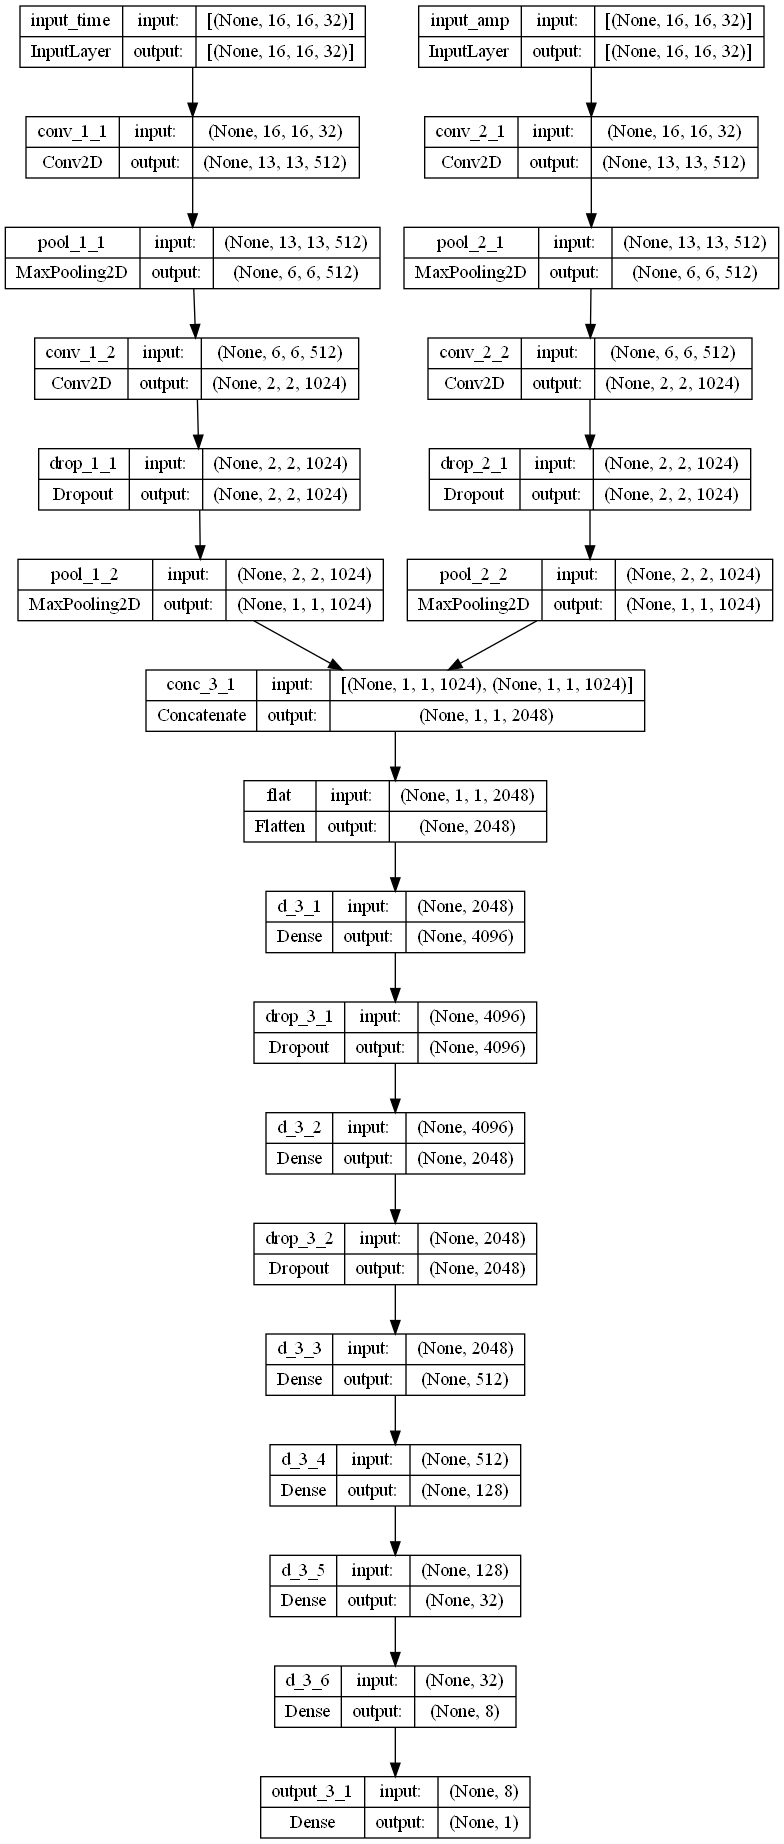

In [20]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [21]:
# Создание и настройка колбэков

callback_list = [] # массив колбэков до подачи в колбек "callbacklist"

FIT_callback_list = keras.callbacks.CallbackList(
            callbacks = callback_list, 
            add_history = CBL_add_history, 
            add_progbar = CBL_add_progbar, 
            model = model
            )

In [ ]:
history = model.fit([X_time_train, X_amp_train],
                    Y_binary_train,
                    batch_size = FIT_batch_size, 
                    epochs = FIT_epochs, 
                    verbose = FIT_verbose, 
                    validation_data = ([X_time_val, X_amp_val], Y_binary_val), 
                    callbacks = FIT_callback_list)


    157/Unknown - 63s 393ms/step - loss: 0.1195

In [ ]:
fig, ax = plt.subplots()

fig.set_figwidth(12)
fig.set_figheight(8)

plt.plot(history.history['loss'], 
         label='Тренировочная выборка',  linewidth=1.5, color='blue')
plt.plot(history.history['val_loss'], linestyle = '--', 
         label='Валидационная выборка',  linewidth=3, color='red')

ax.set_xlabel('Номер эпохи', fontsize=20)
ax.set_ylabel('Значение функции ошибки', fontsize=20)
ax.set_title(f"График значений функции ошибки во время обучения", fontsize=20, pad=15)

ax.patch.set_alpha(0)

#  Устанавливаем форматирование делений:
ax.tick_params(axis='both', which='both', labelsize = 20)

# Вывод и настройка сетки
ax.minorticks_on()
ax.grid(which='major', linewidth=2)
ax.grid(which='minor', color = 'gray', linestyle = ':')

ax.legend(fontsize = 20, facecolor = "white", loc = 'upper right')

plt.show()

In [ ]:
# сохранение модели в файл
model.save(f"networks/CNN/id=v02n04_in(16x16+16x16)_out(1)_train=0dot0_test=0dot0.h5", save_format="h5")

#### 